In [ ]:
# https://www.kaggle.com/datasets/crawford/emnist?select=emnist-balanced-test.csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from keras.layers import Conv2D, Input, Dense, Activation, Flatten, MaxPool2D, MaxPooling2D
from keras import models
from keras.optimizers import Adam


drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/EKKE 2023 24/Neuralis halozatok alkalmazasa/data/"

np.random.seed(5)

# LOAD & SHUFFLE DATASET
df_train = pd.read_csv(f"{drive_path}emnist-digits-train.csv")
df_train = df_train.iloc[np.random.permutation(len(df_train))]


# PREPROCESSING DATA
sample_size = df_train.shape[0]
validation_size = int(df_train.shape[0] * 0.1)

train_x_df = pd.DataFrame(df_train.iloc[:sample_size - validation_size, 1:].values.reshape(-1, 28*28), columns=[f"Pixel_{i}" for i in range(28*28)])
train_y_df = pd.DataFrame(df_train.iloc[:sample_size - validation_size, 0].values, columns=["Label"])
val_x_df = pd.DataFrame(df_train.iloc[sample_size - validation_size:, 1:].values.reshape(-1, 28*28), columns=[f"Pixel_{i}" for i in range(28*28)])
val_y_df = pd.DataFrame(df_train.iloc[sample_size - validation_size:, 0].values, columns=["Label"])

train_x = train_x_df.values.reshape([sample_size - validation_size, 28, 28, 1])
train_y = train_y_df.values.reshape([sample_size - validation_size, 1])
val_x = val_x_df.values.reshape([validation_size, 28, 28, 1])
val_y = val_y_df.values.reshape([validation_size, 1])

# Normalize pixels
train_x, val_x = train_x / 255, val_x / 255

def print_data_info():
  print(f"Sample size (images): {sample_size:,.0f}\nValidation size (images): {validation_size:,.0f}\n")
  print("train_x_df head(5):")
  print(train_x_df.head(5))
  print("\ntrain_y_df head(5):")
  print(train_y_df.head(5))
  print("\nval_x_df head(5):")
  print(val_x_df.head(5))
  print("\nval_y_df head(5):")
  print(val_y_df.head(5))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATASET INFO

In [ ]:
print_data_info()

Sample size (images): 239,999
Validation size (images): 23,999

train_x_df head(5):
   Pixel_0  Pixel_1  Pixel_2  Pixel_3  Pixel_4  Pixel_5  Pixel_6  Pixel_7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   Pixel_8  Pixel_9  ...  Pixel_774  Pixel_775  Pixel_776  Pixel_777  \
0        0        0  ...          0          0          0          0   
1        0        0  ...          0          0          0          0   
2        0        0  ...          0          0          0          0   
3        0        0  ...          0          0          0          0   
4        0        0  ...          0          0          0          0   

   Pixel_778  Pixel_

# MODEL DEFINITION


##Simplified LeNet-5 CNN architecture
Created by Yann LeCun, Léon Bottou, Yoshua Bengio, and Patrick Haffner for image classification tasks, including handwritten digit recognition.

###Input Layer:
Input shape: (28, 28, 1)  
This suggests that the model is designed to handle grayscale images of size 28x28 pixels.

###Convolutional Layers:
**First Convolutional Layer:**  
Filters: 6  
Kernel size: (5, 5)  
Activation function: ReLU (Rectified Linear Unit)  
This layer applies 6 convolutional filters to the input image, each of size 5x5, using the ReLU activation function.

**MaxPooling Layer:**  
Pool size: (2, 2)  
This layer performs max pooling with a pool size of 2x2, reducing the spatial dimensions of the representation.

**Second Convolutional Layer:**  
Filters: 16  
Kernel size: (5, 5)  
Activation function: ReLU  
Similar to the first convolutional layer, but with more filters.

**MaxPooling Layer:**  
Pool size: (2, 2)  
Another max pooling layer to further reduce spatial dimensions.

###Flatten Layer:
This layer flattens the 3D output to a 1D vector, preparing the data for input into the dense layers.

###Dense Layers:
**First Dense Layer:**  
Neurons: 120   
Activation function: ReLU  
This fully connected layer introduces non-linearity to the model.

**Second Dense Layer:**  
Neurons: 84  
Activation function: ReLU  
Another fully connected layer with a smaller number of neurons.

**Output Layer:**  
Neurons: 10  
Activation function: Softmax  
This layer produces a probability distribution over the 10 possible digit classes (0 through 9) using the softmax activation function.


COMMENCING TRAINING:
Training model 1 with u1=6 and u2=16
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 24, 6)         96        
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 12, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 8, 16)         1456      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                               

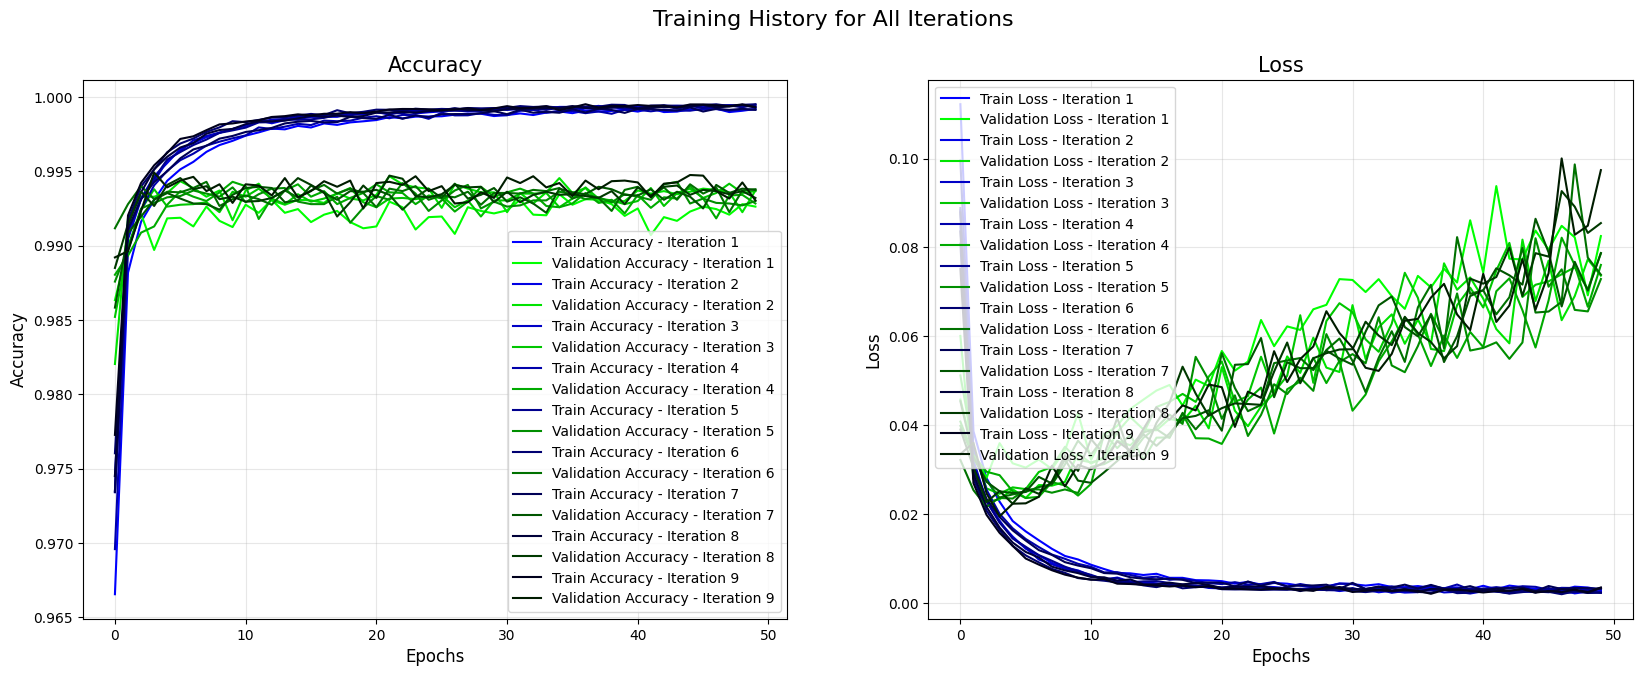

In [ ]:
u1 = [6, 12, 24]
u2 = [16, 32, 48]
results = []

# Define the base colors
num_shades = 9
blue_base_color = [0, 0, 1]
green_base_color = [0, 1, 0]
# Create gradients from light to dark for both blue and green
training_colors = [np.array(blue_base_color) * (1 - i / num_shades) for i in range(num_shades)]
validation_colors = [np.array(green_base_color) * (1 - i / num_shades) for i in range(num_shades)]


for i in range(len(u1)):
    for j in range(len(u1)):
        model = models.Sequential()
        model.add(Conv2D(u1[i], (3, 5), activation='relu', input_shape=(28, 28, 1)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(u2[j], (3, 5), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(120, activation='relu'))
        model.add(Dense(84, activation='relu'))
        model.add(Dense(10, activation='softmax'))

        # MODEL COMPILATION
        initial_learning_rate = 0.001
        batch_size = 64
        epochs = 50
        loss = "sparse_categorical_crossentropy"
        model.compile(Adam(learning_rate=initial_learning_rate),
                      loss=loss,
                      metrics=['accuracy'])

        print(f"\nCOMMENCING TRAINING:\nTraining model {i*3 + j+1} with u1={u1[i]} and u2={u2[j]}")

        model.summary()

        # TRAIN MODEL
        history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_data=[val_x, val_y])

        result_entry = {
            'u1': u1[i],
            'u2': u2[j],
            'history': history.history
        }
        results.append(result_entry)

# PLOT TRAINING /ij
f, axes = plt.subplots(1, 2, figsize=(20, 7))
f.suptitle("Training History for All Iterations", fontsize=16)

for i, result in enumerate(results):
    # accuracy
    axes[0].plot(result['history']['accuracy'], label=f"Train Accuracy - Iteration {i + 1}", color=training_colors[i])
    axes[0].plot(result['history']['val_accuracy'], label=f"Validation Accuracy - Iteration {i + 1}", color=validation_colors[i])
    axes[0].set_title("Accuracy", fontsize=15)
    axes[0].set_xlabel("Epochs", fontsize=12)
    axes[0].set_ylabel("Accuracy", fontsize=12)
    axes[0].grid(alpha=0.3)
    axes[0].legend()
    # loss
    axes[1].plot(result['history']['loss'], label=f"Train Loss - Iteration {i + 1}", color=training_colors[i])
    axes[1].plot(result['history']['val_loss'], label=f"Validation Loss - Iteration {i + 1}", color=validation_colors[i])
    axes[1].set_title("Loss", fontsize=15)
    axes[1].set_xlabel("Epochs", fontsize=12)
    axes[1].set_ylabel("Loss", fontsize=12)
    axes[1].grid(alpha=0.3)
    axes[1].legend()
plt.show()


# VALIDATION

750/750 [==============================] - 2s 3ms/step

Errors in validation set: 167
Validation set total: 23999
Error: 0.6959%
Accuracy: 99.3041%



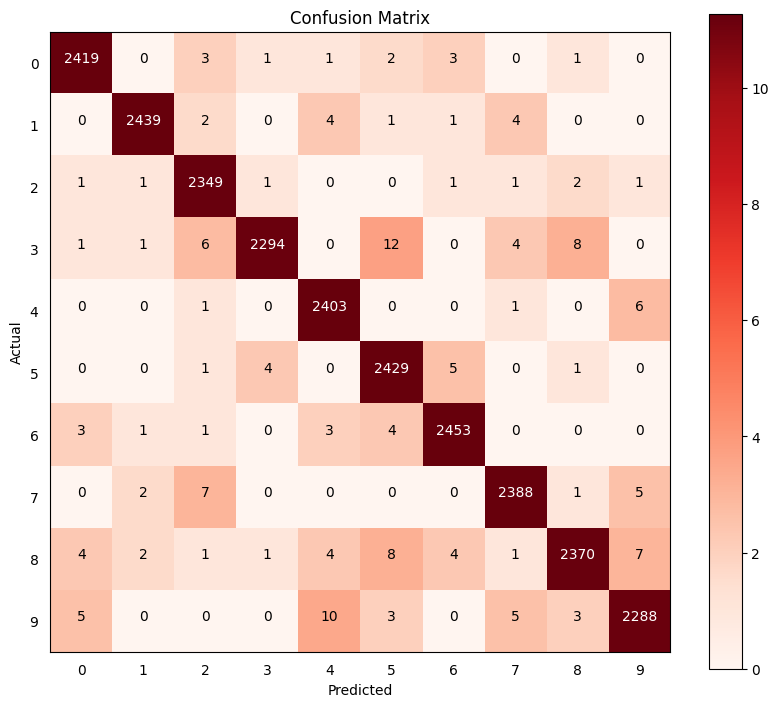

In [ ]:
# EVALUATION
val_p = np.argmax(model.predict(val_x), axis=1)
error = np.sum(val_y.flatten() != val_p)
accuracy = 100 - (error * 100) / val_p.shape[0]
print(f"\nErrors in validation set: {error}")
print(f"Validation set total: {val_p.shape[0]}")
print("Error: {:.4f}%".format((error * 100) / val_p.shape[0]))
print("Accuracy: {:.4f}%\n".format(accuracy))

# CONFUSION MATRIX
confusion_matrix = np.zeros([10, 10])
for i in range(val_x.shape[0]):
    confusion_matrix[val_y[i], val_p[i]] += 1


# Plot confusion matrix
f = plt.figure(figsize=(10, 8.5))
plt.imshow(np.log2(confusion_matrix + 1), cmap="Reds")
plt.colorbar()
plt.tick_params(size=5, color="white")
plt.xticks(np.arange(0, 10), np.arange(0, 10))
plt.yticks(np.arange(0, 10), np.arange(0, 10))

threshold = confusion_matrix.max() / 2
for i in range(10):
    for j in range(10):
        plt.text(j, i, int(confusion_matrix[i, j]),
                 horizontalalignment="center", color="white" if confusion_matrix[i, j] > threshold else "black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#TESTING

1250/1250 [==============================] - 2s 2ms/step


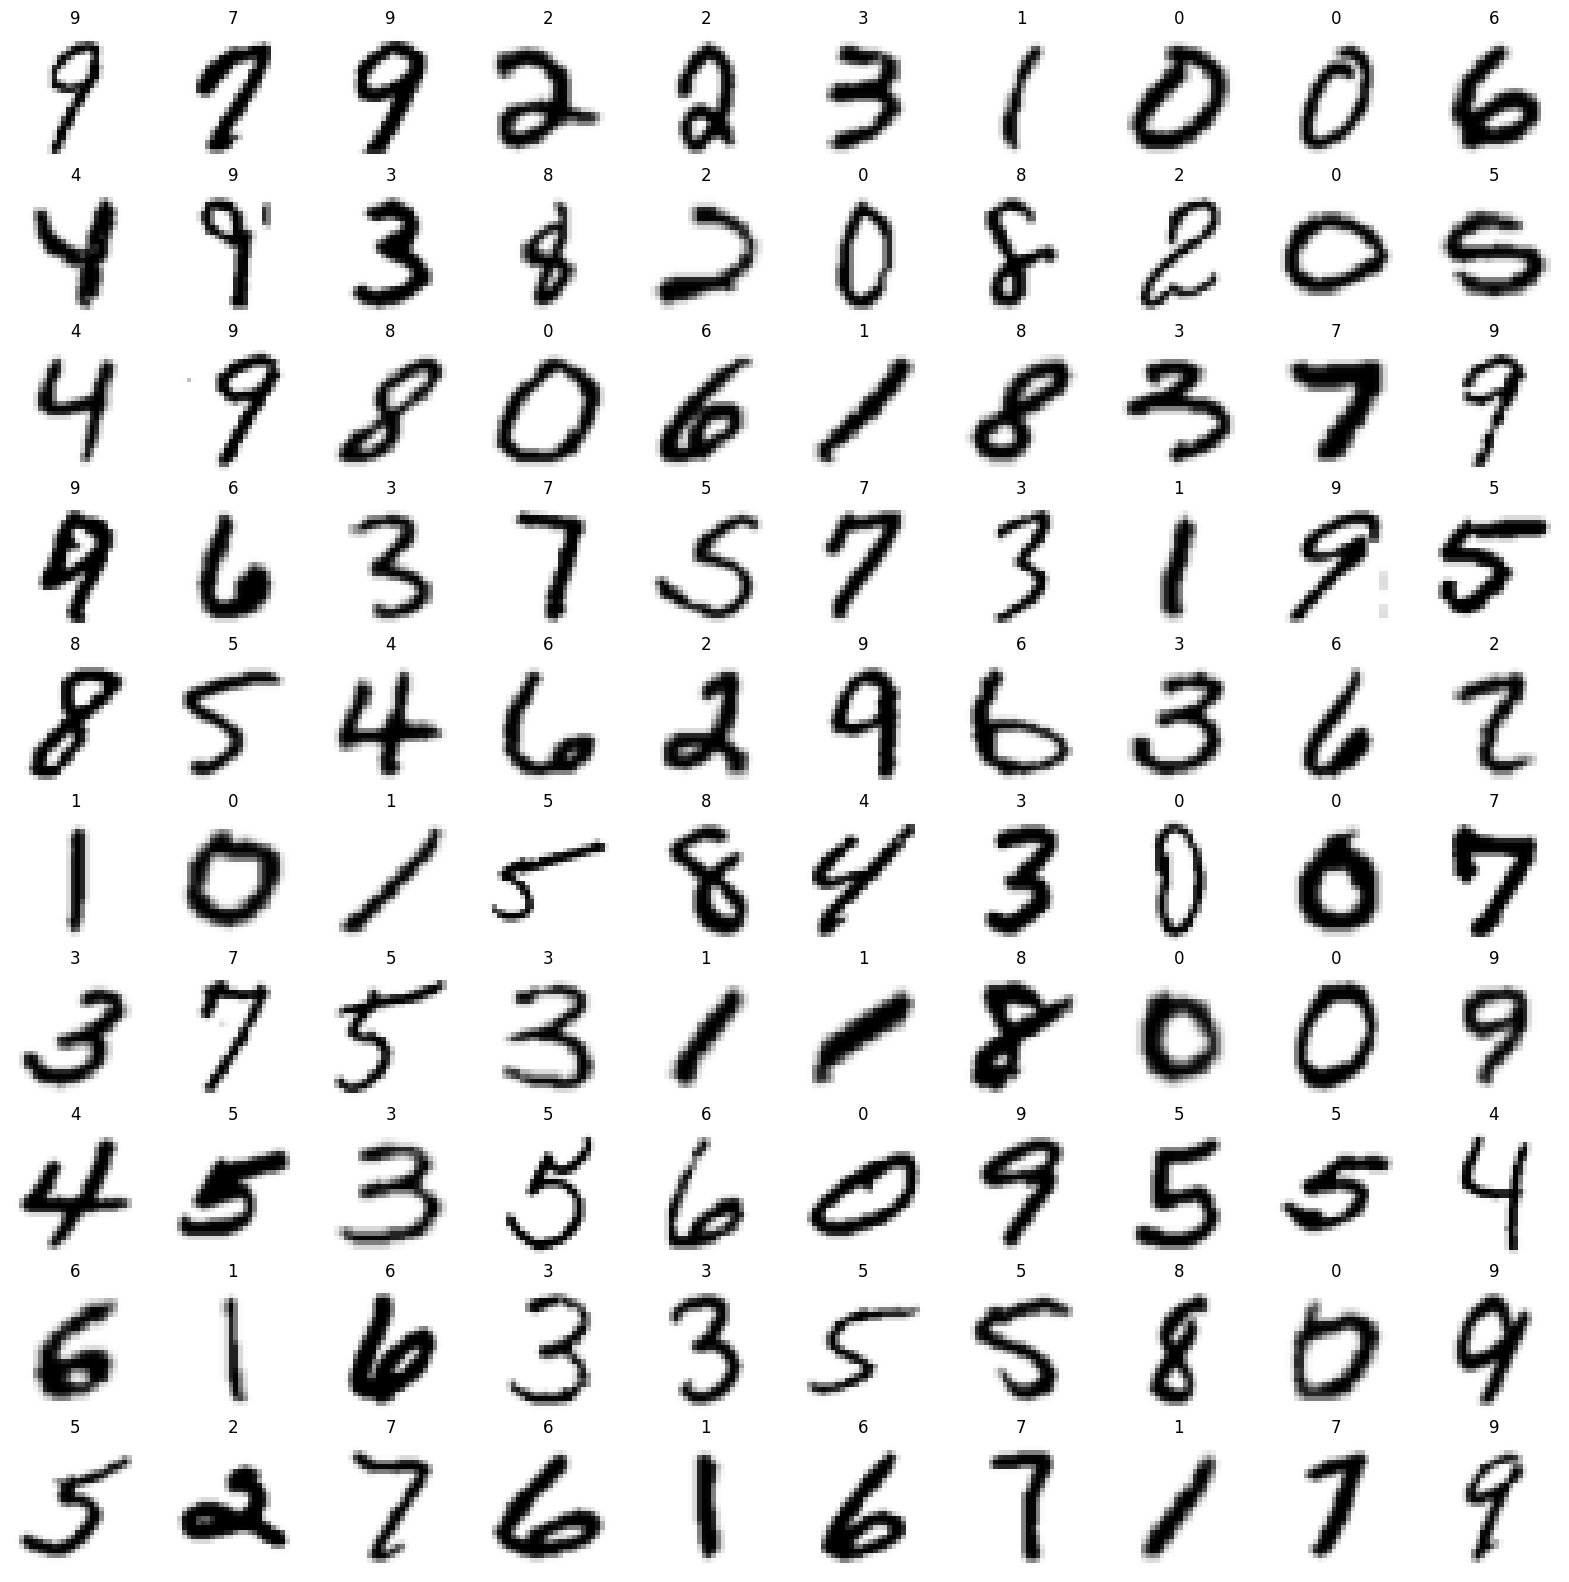

In [ ]:
df_test = pd.read_csv(f"{drive_path}emnist-digits-test.csv")
# Split off the first column
sample_size_test = df_test.shape[0]
test_x = np.asarray(df_test.iloc[:, 1:]).reshape([-1, 28, 28, 1])
# Normalize pixel values
test_x = test_x / 255

# Test predictions
test_y = np.argmax(model.predict(test_x), axis=1)

# Display test set predictions with rotated images
rows, cols = 10, 10
f = plt.figure(figsize=(2 * cols, 2 * rows))
for i in range(rows * cols):
    # Extract the pixel values of the chosen image using iloc
    image_pixels = test_x[i].reshape(28, 28)

    # Rotate the image 90 degrees clockwise
    rotated_image_pixels = np.rot90(image_pixels, k=1)

    # Display the rotated image using matplotlib with origin='lower'
    f.add_subplot(rows, cols, i + 1)
    plt.imshow(rotated_image_pixels, cmap="gray_r", origin="lower")
    plt.gca().set_facecolor('white')
    plt.axis("off")
    plt.title(str(test_y[i]))

plt.show()
